เคสนี้เราจะทำนายยอดขาย ของร้านขายยาในเครือ Rossmann ที่มีกว่า 3000 สาขา ใน 7 ประเทศแถบยุโรป โดยเราจะทำนายจากข้อมูล ร้านค้า โปรโมชั่น ข้อมูลคู่แข่ง และข้อมูลประกอบภายนอก ได้แก่ Google Trends, พยากรณ์อากาศ, etc.

# 0. Magic Commands


In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [15]:
from fastai import *
from fastai.tabular import *

# 2. ข้อมูล

เคสนี้เราจะใช้ Dataset ชื่อ [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) จาก Kaggle

Rossmann เป็นเชนร้านขายยา ที่มีมากกว่า 3000 สาขาใน 7 ประเทศแถบยุโรป ผู้จัดการสาขามีหน้าที่ประเมินยอดขายรายวัน ล่วงหน้า ตั้งแต่วันรุ่งขึ้น ไปจนถึง 6 สัปดาห์ข้างหน้า ยอดขายของแต่ละสาขาจะมากขึ้นหรือน้อยลง ขึ้นอยู่กับหลายปัจจัย เช่น โปรโมชั่น คู่แข่ง วันหยุดโรงเรียน วันหยุดราชการ เทศกาลต่าง ๆ

ใน Dataset จะมีข้อมูลประวัติยอดขาย ระหว่างวันที่ 1 Jan 2013 - 31 July 2015 ของ 1115 สาขา ในประเทศเยอรมัน หน้าที่ของเราก็คือ ทำนายยอดขายใน Column Sales ใน Test Set 

มีไฟล์ดังนี้

* train.csv - ข้อมูลสาขา และประวัติการขาย
* test.csv - ข้อมูลสาขา ไม่รวมยอดขาย
* sample_submission.csv - ตัวอย่างไฟล์สำหรับ Submit
* store.csv - ขื้อมูลสาขาเพิ่มเติม 

ข้อมูลเพิ่มเติม 

* state_names.csv
* googletrend.csv
* store_states.csv

หมายเหตุ บางสาขากำลังปิด เพื่อ Renovate

รัน cell ด้านล่างเพื่อดาวน์โหลด Dataset

In [16]:
# ! wget http://files.fast.ai/part2/lesson14/rossmann.tgz 
# ! mv ./rossmann.tgz ~/.fastai/data
# ! mkdir ~/.fastai/data/rossmann
# ! tar -xvzf ~/.fastai/data/rossmann.tgz -C ~/.fastai/data/rossmann

In [17]:
path=Config().data_path()/Path('rossmann/')

## 2.1 ดูรายการไฟล์

ls ดูว่ามีไฟล์อะไรบ้าง

In [18]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/rossmann/state_names.csv'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/joined'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/test.csv'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/googletrend.csv'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/weather.csv'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/joined_test'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/store.csv'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/train_clean'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/df'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/store_states.csv'),
 PosixPath('/home/jupyter/.fastai/data/rossmann/test_clean')]

ใช้ Pandas read_csv ไปใส่ DataFrame ตามชื่อไฟล์

In [19]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(path/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

## 2.2 ดูข้อมูลทุกตาราง

เป็นการดี ที่เราสำรวจข้อมูลก่อน เพื่อจะได้รู้จักหน้าตาข้อมูลในทุกตาราง

In [20]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [21]:
train.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,2013-12-23,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,986159,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [22]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [23]:
store_states.head()

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


In [24]:
state_names.head()

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


In [25]:
googletrend.head()

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


In [26]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


In [27]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


## 2.3 Feature Engineering

### แปลงชนิดข้อมูล train.StateHoliday 

ดูข้อมูลวันหยุดราชการ ว่ามีค่าอะไรบ้าง a = public holiday วันหยุดราชการ, b = Easter holiday วันอีสเตอร์, c = Christmas วันคริสต์มาส, 0 = None

In [28]:
train.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

แต่ละค่ามีจำนวนเท่าไร

In [29]:
train.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

จะเห็นว่าข้อมูล skew มาก เราจะแปลงให้เป็น boolean ว่าเป็นวันหยุด หรือไม่เป็นวันหยุด เท่านั้น

In [30]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

หลังแปลง

In [31]:
train.StateHoliday.value_counts()

False    986159
True      31050
Name: StateHoliday, dtype: int64

### แตก Field ใหม่

ในตาราง googletrend ข้อมูลจะมาเป็น ช่วงวัน เราจะแตก Column เป็น Date ของวันที่เริ่ม และ แตก Column State ออกมาจากท้ายรหัสใน file 

In [18]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

เราจะแยก googletrend ของทั้งประเทศเยอรมันไว้ต่างหาก เป็นอีกตาราง

In [19]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

### Date Part

เราสามารถทำ Feature Engineering แตก Date ออกเป็น Column ย่อย ๆ เพื่อให้โมเดล มอง Pattern ได้ง่ายขึ้น เช่น ปี เดือน วัน สัปดาห์ วันที่เท่าไรของสัปดาห์ วันที่เท่าไรของปี เป็นวันสิ้นเดือนหรือไม่ เป็นวันต้นเดือนหรือไม่ เป็นวันสิ้นใตรมาสหรือไม่ เป็นวันสิ้นปีหรือไม่ etc.

เพราะ วันสิ้นเดือน วันสุดสัปดาห์ วันสิ้นปี น่าจะมีผลต่อยอดขาย ต่างกับวันธรรมดา

In [20]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [21]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [22]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800


### Join ตารางเข้าด้วยกัน

Join ข้อมูลเข้าด้วยกัน เป็นตารางใหญ่ตารางเดียว

In [23]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [24]:
weather = join_df(weather, state_names, "file", "StateName")

In [25]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [26]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [27]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [28]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [29]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [30]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [31]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

fillna

In [32]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

สร้าง Field Date ขึ้นมาจาก 2 Field Number และใช้ Field ใหม่นั้น คำนวน จำนวนวันตั้งแต่คู่แข่งเปิดสาขา

In [33]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

Clear ข้อมูล Error

In [34]:

for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [35]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

### Week

In [36]:
# ! pip install isoweek

In [37]:
from isoweek import Week
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [38]:

for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [39]:
joined.to_pickle(path/'joined')
joined_test.to_pickle(path/'joined_test')

### Durations

In [40]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [41]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [42]:
#df = train[columns]
df = train[columns].append(test[columns])

In [43]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [44]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [45]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [46]:
df = df.set_index("Date")

In [47]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [48]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

### Rolling

In [49]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [50]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [51]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [52]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [53]:
df.reset_index(inplace=True)

In [54]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [55]:
df.drop(columns,1,inplace=True)

In [56]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [57]:
df.to_pickle(path/'df')

In [58]:
df["Date"] = pd.to_datetime(df.Date)

In [59]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [60]:
joined = pd.read_pickle(path/'joined')
joined_test = pd.read_pickle(path/f'joined_test')

In [61]:
joined = join_df(joined, df, ['Store', 'Date'])

In [62]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [63]:
joined = joined[joined.Sales!=0]

In [64]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [65]:
joined.to_pickle(path/'train_clean')
joined_test.to_pickle(path/'test_clean')

# 3. เตรียมข้อมูล



ss

In [265]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [266]:
len(train_df),len(test_df)

(844338, 41088)

In [267]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [268]:
procs=[FillMissing, Categorify, Normalize]

In [269]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [270]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [271]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [272]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [273]:
valid_idx = range(cut)

In [274]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

สร้าง Databunch จากการกำหนดค่าด้านบน

In [275]:
databunch = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

## สำรวจข้อมูล ##


*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [276]:
databunch.show_batch(rows=10)

Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,target
136,6,2014,3,8,False,24,25,a,c,"Feb,May,Aug,Nov",2010,2012,BY,10,Fog,0.0,5.0,0.0,0.0,0.0,5.0,False,True,-0.4166,-0.1072,-0.5185,-1.0324,0.8653,-0.1112,-0.8959,-0.9548,-0.6483,0.2552,-1.1341,-1.1325,0.7203,-0.0781,-0.8994,-0.4796,8.505526
911,5,2013,3,1,False,0,0,a,c,#na#,1900,1900,SH,9,#na#,4.0,0.0,0.0,0.0,0.0,0.0,False,False,1.4146,-0.7085,-0.8004,-0.8747,-0.0532,0.3488,0.5300,-0.9548,-0.3129,-0.3604,-0.8622,-1.1325,0.6572,0.3223,-0.8994,-0.4796,9.204724
598,2,2013,9,10,False,0,0,c,a,"Jan,Apr,Jul,Oct",2013,2014,BY,37,Rain,4.0,2.0,0.0,0.0,2.0,5.0,False,False,-0.6281,0.1333,0.1863,0.2293,0.8653,1.1921,1.3447,0.0439,-0.6483,0.2552,-1.3154,-1.5649,-0.3854,0.4763,1.1119,2.0852,8.821142
86,3,2013,7,31,False,24,0,a,a,"Jan,Apr,Jul,Oct",2005,2013,NW,31,Rain,3.0,3.0,0.0,0.0,5.0,5.0,False,False,-0.6370,1.3360,1.5960,1.8065,0.0780,-0.2645,-0.3357,1.0426,1.5318,-0.3604,0.0441,-0.5921,0.7519,-0.7866,1.1119,2.0852,8.793916
46,2,2014,4,1,False,24,25,c,a,"Jan,Apr,Jul,Oct",2005,2011,BY,14,Fog,4.0,2.0,0.0,0.0,0.0,0.0,False,True,-0.5448,0.4941,-0.0956,-0.7169,0.8653,-0.1879,-0.8450,-1.2877,-1.1514,0.2552,-0.5904,-0.9164,1.4786,0.6611,1.1119,-0.4796,8.639941
926,1,2015,3,23,False,24,25,d,c,"Jan,Apr,Jul,Oct",2011,2010,NW,13,#na#,0.0,4.0,0.0,0.0,0.0,0.0,False,False,-0.0386,-0.2275,-0.5185,-0.8747,-1.6279,-0.5712,-0.4885,0.0439,-0.1452,0.2552,1.3129,1.0292,1.3522,0.8460,-0.8994,-0.4796,8.740657
874,2,2013,10,29,False,0,0,a,a,#na#,1900,1900,"HB,NI",44,Rain,1.0,3.0,0.0,0.0,0.0,0.0,False,False,-0.2872,-0.1072,0.1863,0.5448,-1.4966,-0.4945,0.1226,1.2646,1.8672,-1.5917,-1.0435,0.0564,-0.3854,-0.5709,-0.8994,-0.4796,8.147867
705,6,2014,8,2,False,22,25,a,a,"Feb,May,Aug,Nov",2012,2011,NW,31,Rain-Thunderstorm,5.0,5.0,0.0,0.0,5.0,5.0,False,False,-0.1680,1.6968,2.0189,2.1219,0.0780,-1.0312,-1.0996,0.4878,0.3579,0.2552,1.5848,0.9211,0.1833,-0.7249,-0.8994,-0.4796,8.557375
604,6,2013,9,21,False,0,0,d,a,#na#,2014,1900,BY,38,Fog,5.0,0.0,0.0,0.0,0.0,0.0,False,False,0.7047,0.2536,0.1863,0.2293,0.8653,0.7321,0.6318,-0.9548,-0.3129,0.2552,-0.5904,-0.5921,-0.0379,0.8152,-0.8994,-0.4796,8.8386965
877,3,2013,10,23,False,0,0,a,c,#na#,1900,1900,SH,43,#na#,3.0,3.0,0.0,0.0,0.0,2.0,False,False,3.0421,0.7346,1.1731,1.4911,-0.7093,0.3488,1.0901,-0.1780,0.1902,-1.5917,-0.0466,-0.5921,-0.5750,-0.7558,1.1119,-0.4796,8.808518


aa

# 4. สร้างโมเดล

เนื่องจากตารางเล็ก ๆ ไม่ซับซ้อน เราจะสร้างโมเดล ที่ประกอบด้วย Dense Layer ที่ Deep แค่ 2 Hidden Layer โดยที่เหลือใช้ค่า Default ทั้งหมด เรื่องชนิดของ Layer เช่น Dense ไว้เราจะอธิบายต่อไป

In [277]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [278]:
learner = tabular_learner(databunch, layers=[1024, 512], 
                          ps=[0.001,0.01], emb_drop=0.04, 
                          y_range=y_range, metrics=exp_rmspe, 
                          callback_fns=[ShowGraph])

# 5. เริ่มต้นเทรนโมเดล

เทรน 3 Cycle

In [279]:
len(databunch.train_ds.cont_names)

16

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.026519,0.019520,0.141976,02:02
1,0.028613,0.026763,0.164934,02:00
2,0.026084,0.020839,0.146232,02:00
3,0.021008,0.021318,0.130962,02:00
4,0.015833,0.017236,0.121483,02:00
5,0.011017,0.011813,0.107651,02:01


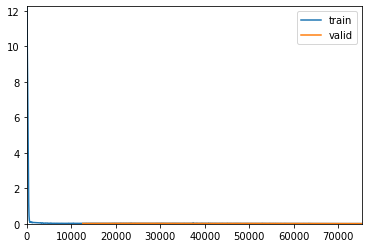

In [280]:
learner.fit_one_cycle(6, max_lr=3e-3, wd=0.2)

In [281]:
learner.save("05b-tabular-rossmann-1")

In [282]:
learner.load("05b-tabular-rossmann-1");

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011120,0.011917,0.109617,02:01
1,0.013211,0.013224,0.111307,02:00
2,0.012968,0.013314,0.114533,02:01
3,0.011680,0.013893,0.109955,01:59
4,0.011230,0.011875,0.109455,02:01
5,0.010331,0.011199,0.102845,02:00
6,0.009918,0.010766,0.101879,02:01
7,0.009664,0.010932,0.102530,02:01


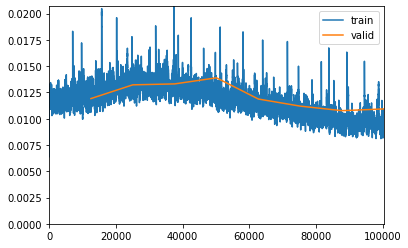

In [283]:
learner.fit_one_cycle(8, max_lr=3e-4, wd=0.1)

In [284]:
learner.save("05b-tabular-rossmann-2")

In [285]:
learner.load("05b-tabular-rossmann-2");

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.009136,0.011866,0.104267,02:04
1,0.010415,0.011593,0.104389,02:01
2,0.009622,0.012416,0.106174,02:01
3,0.010421,0.011347,0.102362,02:02
4,0.009837,0.010654,0.102949,02:00
5,0.009595,0.011319,0.102928,02:01
6,0.009244,0.010609,0.101638,02:01
7,0.008745,0.010683,0.101775,02:01


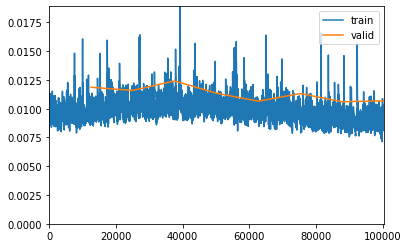

In [290]:
learner.fit_one_cycle(8, max_lr=1e-4, wd=0.1)

In [291]:
learner.save("05b-tabular-rossmann-3")

In [292]:
learner.load("05b-tabular-rossmann-3");

## สำเร็จแล้ว ##

เพียงแค่เวลา x นาที เราเทรน Model ได้ accuracy ประมาณ xx หรือ ความแม่นยำประมาณ xx%


# 6. ดูผลลัพธ์

ลองดูข้อมูล Record ที่ 850

In [293]:
row = df.iloc[850]
row

Store                                       852
DayOfWeek                                     5
Year                                       2015
Month                                         7
Day                                          31
StateHoliday                              False
CompetitionMonthsOpen                        24
Promo2Weeks                                  25
StoreType                                     c
Assortment                                    a
PromoInterval                   Jan,Apr,Jul,Oct
CompetitionOpenSinceYear                   2004
Promo2SinceYear                            2011
State                                        HE
Week                                         31
Events                                      Fog
Promo_fw                                      5
Promo_bw                                      5
StateHoliday_fw                               0
StateHoliday_bw                               0
SchoolHoliday_fw                        

ให้โมเดลทำนายกัน

In [294]:
np.exp(learner.predict(row)[0].data)[0], row.Sales

(5352.605, 5722)

โมเดลทำนายได้ใกล้เคียง

In [295]:
test_preds=learner.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

In [296]:
# ! kaggle competitions submit rossmann-store-sales -f {'rossmann_submission.csv'} -m "My submission"

100%|████████████████████████████████████████| 434k/434k [00:13<00:00, 33.5kB/s]
Successfully submitted to Rossmann Store Sales

# 7. สรุป

1. 

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 6](https://course.fast.ai/videos/?lesson=6)
* [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales)
* [Rossmann Additional Info](http://files.fast.ai/part2/lesson14/rossmann.tgz)